In [23]:
import numpy as np
import pandas as pd 
import shap
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from os import chdir 
chdir("C:\\Users\\afeki\\OneDrive\\Desktop\\code\\BootStrapDesicionTree\\")

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [2]:
from gradient_boosting_trees.gradient_boosting_regressor import CartGradientBoostingRegressor, \
    CartGradientBoostingRegressorKfold
from gradient_boosting_trees.gradient_boosting_abstract import GradientBoostingMachine
from Tree.node import Leaf


from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier

from sklearn.model_selection import train_test_split

import xgboost as xgb

from catboost import Pool, CatBoostRegressor

# Config

In [3]:
import warnings
warnings.filterwarnings('ignore')
results = {}

# Create simulated data
$$ y = a_1 \cdot x_1 + a_2 \cdot I(x_2 \in LEFT\_GROUP) + \sigma $$

$$ x1 - N(0,1) $$

In [4]:
def compute_mse(model_name,model,X,y, transform_x = True, categorical_features = None):
    if transform_x:
        temp_x = X.copy()
        if model_name == 'xgboost':
            temp_x = xgb.DMatrix(temp_x)
        elif model_name == 'catboost':
            if categorical_features:
                temp_x = Pool(temp_x , cat_features = categorical_features)
            else:
                temp_x = Pool(temp_x)
        return np.mean(np.square(y - model.predict(temp_x)))
    return np.mean(np.square(y - model.predict(X)))
    
    
cat_features=[0]

def permutation_feature_importance(model_name,model,X,y, categorical_features = None):
    results = {}
    mse = compute_mse(model_name, model,X,y, categorical_features = categorical_features)
    for col in X.columns:
        temp_x = X.copy()
        temp_x[col] = np.random.permutation(temp_x[col])
        if model_name == 'xgboost':
            temp_x = xgb.DMatrix(temp_x)
        elif model_name == 'catboost':
            if categorical_features:
                temp_x = Pool(temp_x , cat_features = categorical_features)
            else:
                temp_x = Pool(temp_x)
        new_mse = compute_mse(model_name, model,temp_x,y, transform_x = False, categorical_features = categorical_features)
        results[col] = new_mse - mse
    results = pd.Series(results)
    return results/results.sum()

def get_x1_shap_value(model, x, columns = None):
    if columns is None:
        columns = x.columns
    abs_shap_values = pd.DataFrame(shap.TreeExplainer(model, feature_perturbation = "tree_path_dependent").shap_values(x), columns = columns).apply(np.abs)
    return (abs_shap_values.mean()/abs_shap_values.mean().sum())['x1']
    

# OUR IMPLEMENTATION

In [5]:
from utils import all_experiments, create_x_y, n_experiments, get_fitted_model, create_one_hot_x_x_val, create_mean_imputing_x_x_val
from config import N_EXPERIMENTS,N_ROWS, SIGMA, A1, CATEGORY_COLUMN_NAME, Y_COL_NAME, MAX_DEPTH, LEARNING_RATE,VAL_RATIO, N_ESTIMATORS,MODELS_DIR, A2, N_EXPERIMENTS, CATEGORIES, A1_VALUES
EXP_NAME = F"interaction_{MAX_DEPTH}_nestimators_{N_ESTIMATORS}_learning_rate_{LEARNING_RATE}"

In [15]:
model_type= 'ours'
for exp_number, category_size, a1 in tqdm(all_experiments(), total=n_experiments):
    np.random.seed(exp_number)
    for predictor_name, predictor in {'Kfold': CartGradientBoostingRegressorKfold,
                                      'CartVanilla': CartGradientBoostingRegressor}.items():
        exp_name = F"{EXP_NAME}__{predictor_name}_exp_{exp_number}_category_size_{category_size}_a1_{a1}"
        model_path = 'experiments/interaction/' /MODELS_DIR / F"{exp_name}.pkl"
        X, y = create_x_y(category_size, a1=a1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_RATIO, random_state=42)
        X_train[Y_COL_NAME] = y_train
        model = get_fitted_model(model_path, predictor, X_train, Y_COL_NAME)
        fi_gain = pd.Series(model.compute_feature_importance(method='gain')).sort_index()
        fi_gain /= fi_gain.sum()
#         fi_split_count = pd.Series(model.compute_feature_importance(method='split_count')).sort_index()
#         fi_split_count /= fi_split_count.sum()
        fi_permutation_train = permutation_feature_importance(model_type,model,X_train,y_train)
        fi_permutation_test = permutation_feature_importance(model_type,model, X_test, y_test)
        temp_results = np.array([fi_gain['x1'], fi_permutation_train['x1'], fi_permutation_test['x1']])
        results.setdefault((F"{model_type}_{predictor_name}", category_size, a1),np.zeros(len(temp_results)))
        results[(F"{model_type}_{predictor_name}", category_size, a1)] += temp_results

100%|██████████| 230/230 [3:21:04<00:00, 52.46s/it]  


## SKLEARN

In [7]:
pd.options.mode.chained_assignment = None 
model_type= 'sklearn'
for exp_number, category_size, a1 in tqdm(all_experiments(), total=n_experiments):
    np.random.seed(exp_number)
    for predictor_name, _ in {'one_hot': GradientBoostingRegressor,
                                      'mean_imputing': GradientBoostingRegressor}.items():
        X, y = create_x_y(category_size, a1=a1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_RATIO, random_state=42)
        if predictor_name == 'one_hot':
            X_train, X_test = create_one_hot_x_x_val(X_train, X_test)
        elif predictor_name == 'mean_imputing':
            X_train, X_test = create_mean_imputing_x_x_val(X_train, y_train, X_test)
    
        model = GradientBoostingRegressor(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE)
        model.fit(X_train, y_train)
        fi_gain = pd.Series(model.feature_importances_, index = X_train.columns)
        fi_gain /= fi_gain.sum()
#         fi_split_count = pd.Series(model.compute_feature_importance(method='split_count')).sort_index()
#         fi_split_count /= fi_split_count.sum()
        fi_permutation_train = permutation_feature_importance(model_type,model,X_train,y_train)
        fi_permutation_test = permutation_feature_importance(model_type,model, X_test, y_test)
        temp_results = np.array([fi_gain['x1'], fi_permutation_train['x1'], fi_permutation_test['x1'], get_x1_shap_value(model, X_train)])
        results.setdefault((F"{model_type}_{predictor_name}", category_size, a1),np.zeros(len(temp_results)))
        results[(F"{model_type}_{predictor_name}", category_size, a1)] += temp_results
        
        

100%|██████████| 230/230 [03:06<00:00,  1.23it/s]


## XGBOOST

In [8]:
model_type= 'xgboost'
for exp_number, category_size, a1 in tqdm(all_experiments(), total=n_experiments):
    np.random.seed(exp_number)
    for predictor_name, _ in {'one_hot': GradientBoostingRegressor,
                                      'mean_imputing': GradientBoostingRegressor}.items():
        X, y = create_x_y(category_size, a1=a1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_RATIO, random_state=42)
        if predictor_name == 'one_hot':
            X_train, X_test = create_one_hot_x_x_val(X_train, X_test)
        elif predictor_name == 'mean_imputing':
            X_train, X_test = create_mean_imputing_x_x_val(X_train,y_train, X_test)
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        param = {'max_depth': MAX_DEPTH - 1, 'eta': LEARNING_RATE, 'objective': 'reg:squarederror'}
        bst = xgb.train(param, dtrain, N_ESTIMATORS)
        fi_gain = pd.Series(bst.get_score(importance_type='gain'))
        fi_gain /= fi_gain.sum()
#         fi_split_count = pd.Series(model.compute_feature_importance(method='split_count')).sort_index()
#         fi_split_count /= fi_split_count.sum()
        fi_permutation_train = permutation_feature_importance(model_type,bst,X_train,y_train)
        fi_permutation_test = permutation_feature_importance(model_type,bst, X_test, y_test)
        temp_results = np.array([fi_gain['x1'],fi_permutation_train['x1'], fi_permutation_test['x1'],  get_x1_shap_value(bst, X_train)])
        results.setdefault((F"{model_type}_{predictor_name}", category_size, a1),np.zeros(len(temp_results)))
        results[(F"{model_type}_{predictor_name}", category_size, a1)] += temp_results

100%|██████████| 230/230 [07:08<00:00,  1.86s/it]


## Catboost

In [9]:
# !pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [10]:
model_type= 'catboost'
for exp_number, category_size, a1 in tqdm(all_experiments(), total=n_experiments):
    np.random.seed(exp_number)
    for predictor_name in ["vanilla","mean_imputing"]:
        X, y = create_x_y(category_size, a1=a1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_RATIO, random_state=42)
        if predictor_name == 'mean_imputing':
            X_train, X_test = create_mean_imputing_x_x_val(X_train,y_train, X_test)
            train_pool = Pool(X_train, y_train)
            val_pool = Pool(X_test,y_test)
        else:
            train_pool = Pool(X_train, y_train, cat_features=[0])
            val_pool = Pool(X_test,y_test, cat_features=[0])
    
        model = CatBoostRegressor(iterations=N_ESTIMATORS, 
                                  depth=MAX_DEPTH, 
                                  learning_rate=LEARNING_RATE, 
                                  loss_function='RMSE',logging_level = 'Silent')
        model.fit(train_pool)
        
        fi_gain = pd.Series(model.feature_importances_, index = model.feature_names_)
        fi_gain /= fi_gain.sum()
    #         fi_split_count = pd.Series(model.compute_feature_importance(method='split_count')).sort_index()
    #         fi_split_count /= fi_split_count.sum()
        cat_feature = [0] if predictor_name == 'vanilla' else None
        fi_permutation_train = permutation_feature_importance(model_type,model,X_train,y_train,  categorical_features = cat_feature)
        fi_permutation_test = permutation_feature_importance(model_type,model, X_test, y_test, categorical_features = cat_feature)
        temp_results = np.array([fi_gain['x1'], fi_permutation_train['x1'], fi_permutation_test['x1'],  get_x1_shap_value(model, train_pool, columns = X_train.columns)])
        results.setdefault((F"{model_type}_{predictor_name}", category_size, a1),np.zeros(len(temp_results)))
        results[(F"{model_type}_{predictor_name}", category_size, a1)] += temp_results

100%|██████████| 230/230 [01:08<00:00,  3.38it/s]


In [16]:
import pickle

for key in results.keys():
    results[key] = results[key]/N_EXPERIMENTS
    
with open('experiments/interaction/feature_importance_ipynb_results.pkl', 'wb') as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)
    
with open('experiments/interaction/feature_importance_ipynb_results.pkl', 'rb') as output:
    results = pickle.load(output)
    

    

In [21]:
experiments = list(set(exp[0] for exp in results.keys()))
categories = sorted(list(set(exp[1] for exp in results.keys())))
a_s = sorted(list(set(exp[2] for exp in results.keys())))

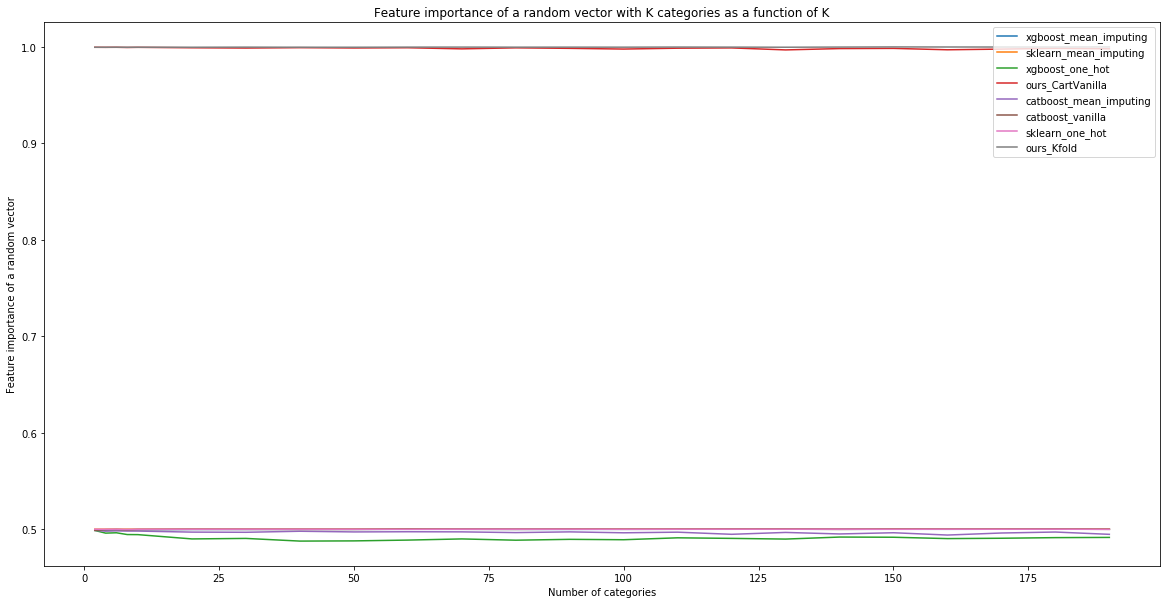

In [22]:
fi_to_location = {'gain' :0, 'permutation_train': 1, 'permutation_test':2}
fi = 'gain'
a = 100
df = pd.DataFrame()
for exp in experiments:
    for cat in categories:   
        df.loc[exp,cat] = results[(exp,cat, a)][fi_to_location[fi]]
        
plt.rcParams['figure.figsize'] = [20, 10]
ax = df.T.plot()
ax.set_xlabel("Number of categories")
ax.set_ylabel("Feature importance of a random vector")
ax.set_title("Feature importance of a random vector with K categories as a function of K")
plt.legend(loc='upper right')
plt.show()

$$ y = a_1 \cdot x_1 + a_2 \cdot I(x_2 \in LEFT\_GROUP) + \sigma $$

$$ x1 - N(0,1) $$

In [14]:
fi_to_location = {'gain' :0, 'permutation_train': 1, 'permutation_test':2}
fi = 'gain'
a = 100 # [2, 10, 50, 100, 200]

def plot_feature_importance(method, a1):
    df = pd.DataFrame()
    for exp in experiments:
        for cat in categories:   
            df.loc[exp,cat] = results[(exp,cat, a1)][fi_to_location[method]]

    plt.rcParams['figure.figsize'] = [20, 10]
    ax = df.T.plot()
    ax.set_xlabel("Number of categories")
    ax.set_ylabel("Feature importance of the category vaector")
    ax.set_title("Feature importance of the category vaector with K categories as a function of K")
    plt.legend(loc='upper right')
    plt.show()
    
